## 1. Revisión de datos

In [757]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')

In [758]:
def csv(path):
    archivo = pd.read_csv(path)
    return archivo

In [759]:
event = csv('event_type.csv')
log_feature = csv('log_feature.csv')
resource = csv('resource_type.csv',)
severity = csv('severity_type.csv')
train = csv('train.csv')
test = csv('test.csv')

In [760]:
print('event')
print(event.head())
print('log_feature')
print(log_feature.head())
print('resource')
print(resource.head())
print('severity')
print(severity.head())
print('train')
print(train.head())

event
     id     event_type
0  6597  event_type 11
1  8011  event_type 15
2  2597  event_type 15
3  5022  event_type 15
4  5022  event_type 11
log_feature
     id  log_feature  volume
0  6597   feature 68       6
1  8011   feature 68       7
2  2597   feature 68       1
3  5022  feature 172       2
4  5022   feature 56       1
resource
       id    resource_type
0  6597.0  resource_type 8
1  8011.0  resource_type 8
2  2597.0  resource_type 8
3  5022.0  resource_type 8
4  6852.0  resource_type 8
severity
     id    severity_type
0  6597  severity_type 2
1  8011  severity_type 2
2  2597  severity_type 2
3  5022  severity_type 1
4  6852  severity_type 1
train
      id      location  fault_severity
0  14121  location 118               1
1   9320   location 91               0
2  14394  location 152               1
3   8218  location 931               1
4  14804  location 120               0


In [761]:
(train.id.nunique()) + (test.id.nunique())

18552

In [762]:
print("====="*6)
print("Tamaño de source:", len(resource))
print("Id's únicos en source:", resource.id.nunique())
print("====="*6)
print("Tamaño de log_feature:", len(log_feature))
print("Id's únicos en log_feature:", log_feature.id.nunique())
print("====="*6)
print("Tamaño de event:", len(event))
print("Id's únicos en event:", event.id.nunique())
print("====="*6)
print("Tamaño de severity:", len(severity))
print("Id's únicos en severity:", severity.id.nunique())
print("====="*6)

Tamaño de source: 22877
Id's únicos en source: 18552
Tamaño de log_feature: 58671
Id's únicos en log_feature: 18552
Tamaño de event: 34082
Id's únicos en event: 18552
Tamaño de severity: 18552
Id's únicos en severity: 18552


Cada Id tiene asignado más de un source, log_feature y evento. Habrá que manipular los DataFrames para condensar toda la información en los DataFrames de train y test respectivamente. En el caso de la variable severity, esa sí tiene asignado un sólo valor para cada id.

Antes del análisis exploratorio, revisemos si no tenemos duplicados.

In [763]:
train.duplicated().sum()

0

In [764]:
event.duplicated().sum()

2912

In [765]:
log_feature.duplicated().sum()

0

In [766]:
resource.duplicated().sum()

1800

In [767]:
severity.duplicated().sum()

0

In [768]:
test.duplicated().sum()

0

Tenemos datos redundantes en event y resource. ¿Qué porcentaje de los datos son estos duplicados?

In [769]:
print('Porcentaje de duplicados en event: ', (event.duplicated().sum())/len(event) * 100)

Porcentaje de duplicados en event:  8.544099524675781


In [770]:
print('Porcentaje de duplicados en resource: ', (resource.duplicated().sum())/len(resource) * 100)

Porcentaje de duplicados en resource:  7.86816453206277


No es un porcentaje significativo. Tiremos sin preocuparnos.

In [771]:
event.drop_duplicates(inplace=True)
resource.drop_duplicates(inplace = True)

Ahora sí, empecemos:

In [772]:
resource.dropna(inplace = True)

--------
## 2. Análisis Exploratorio Descriptivo 1

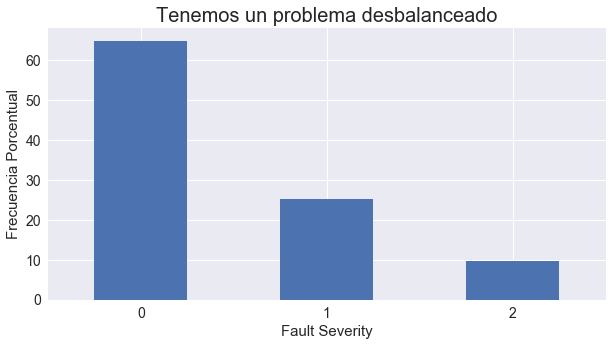

In [773]:
t = (train.fault_severity.value_counts(normalize = True))*100
plt.figure(figsize=(10,5))
t.plot.bar(rot = 0)
plt.xlabel('Fault Severity', fontsize = 15)
plt.ylabel('Frecuencia Porcentual', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Tenemos un problema desbalanceado', fontsize = 20);

### Location number

In [774]:
location = []
for i in range(0, len(train)):
    x = train.location[i].split(" ")[1]
    location.append(x)

In [775]:
train['location_number'] = location

In [776]:
train.location_number = train.location_number.astype(int)

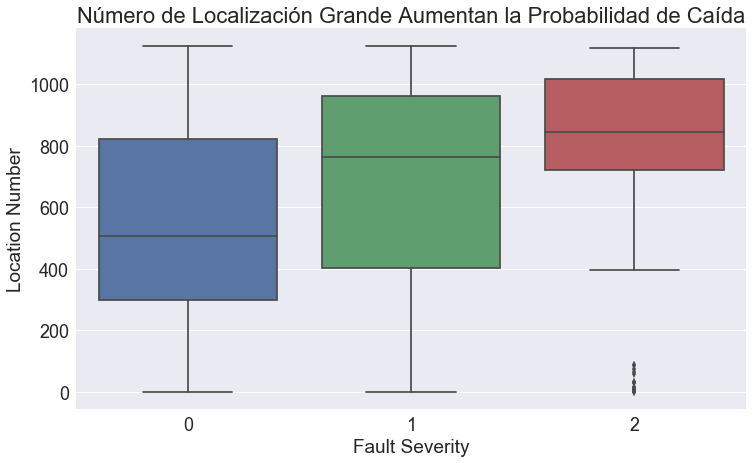

In [777]:
sns.catplot(x="fault_severity", y="location_number", kind="box", data=train[['fault_severity','location_number']], height=6, aspect =1.7)
plt.xlabel('Fault Severity', fontsize = 19)
plt.ylabel('Location Number', fontsize = 19)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.title('Número de Localización Grande Aumentan la Probabilidad de Caída', fontsize = 22);

Esto sugiere que a medida que aumenta el número de la locación la probabilidad de que la falla sea más severa aumenta.

Vemos algunos outliers en el boxplot de fault severity.

Veamos más a fondo los histogramas de location number para cada grado de severidad en caída:

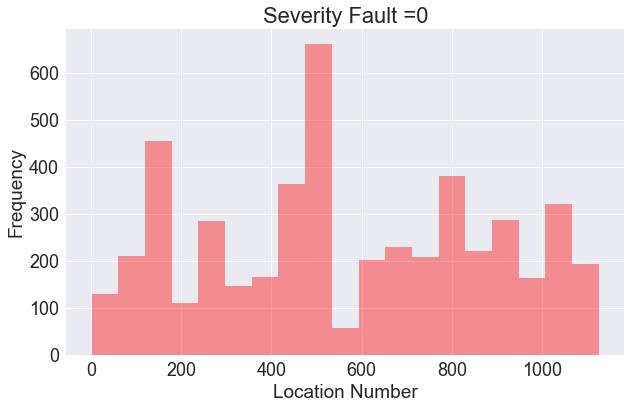

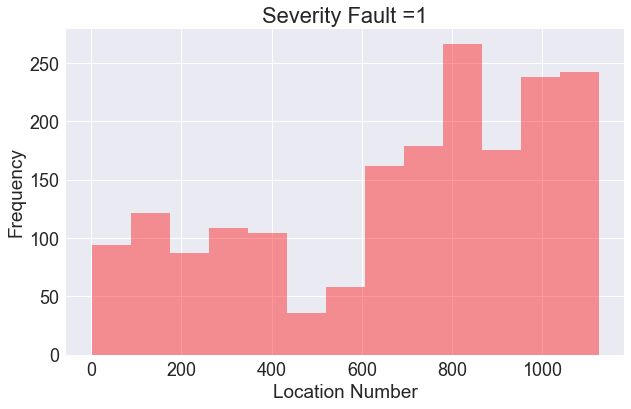

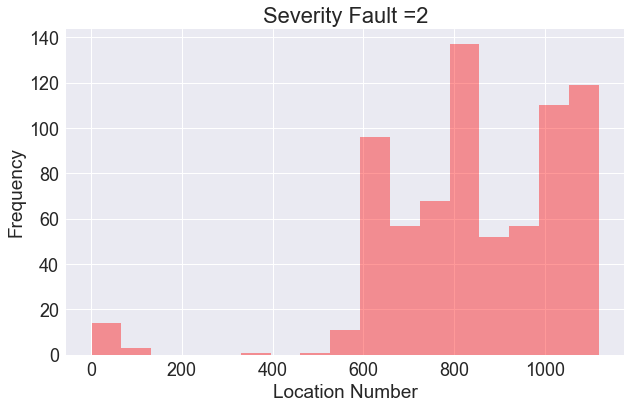

In [778]:
for i in [0,1,2]:
    plt.figure(figsize=(10,6))
    sns.distplot(train[train.fault_severity == i].location_number, color = 'red', kde = False)
    plt.ylabel('Frequency', fontsize = 19)
    plt.xlabel('Location Number', fontsize = 19)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.title('Severity Fault ='+ str(i), fontsize = 22)
    plt.show()
    print("===="*45)

Todo indica a que números de localización altos podrían ayudarnos a predecir fallas del tipo 1 y/ó 2.

### Id

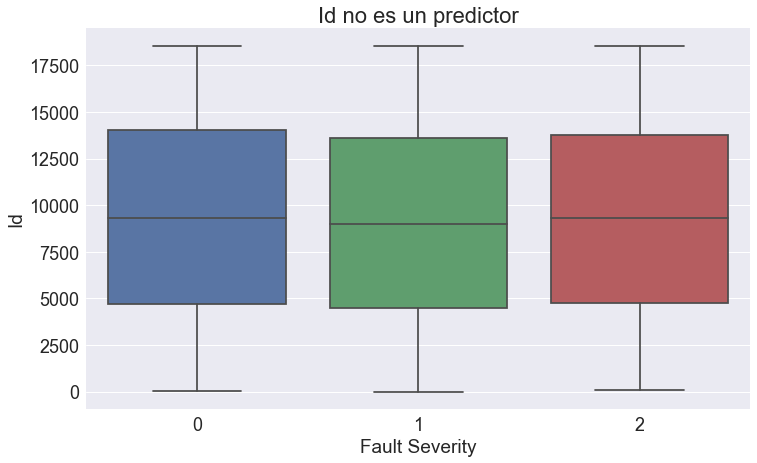

In [779]:
sns.catplot(x="fault_severity", y="id", kind="box", data=train[['fault_severity','id']], height=6, aspect =1.7)
plt.xlabel('Fault Severity', fontsize = 19)
plt.ylabel('Id', fontsize = 19)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.title('Id no es un predictor', fontsize = 22);

El id es una variable inúltil para predecir, sólo la usaremos cómo índice para concatenar las tablas.

### Event_Type

In [780]:
event_number = []
for i in range(len(event)):
    x = int(event.event_type[i].split(' ')[1])
    event_number.append(x)
    
event['event_number'] = event_number

In [781]:
sorted(event.event_number.unique())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54]

In [782]:
len(sorted(event.event_number.unique()))

53

Del 1 al 54, pero tenemos 53 elementos, falta el 16 en forma secuencial. Hagamos un histograma:

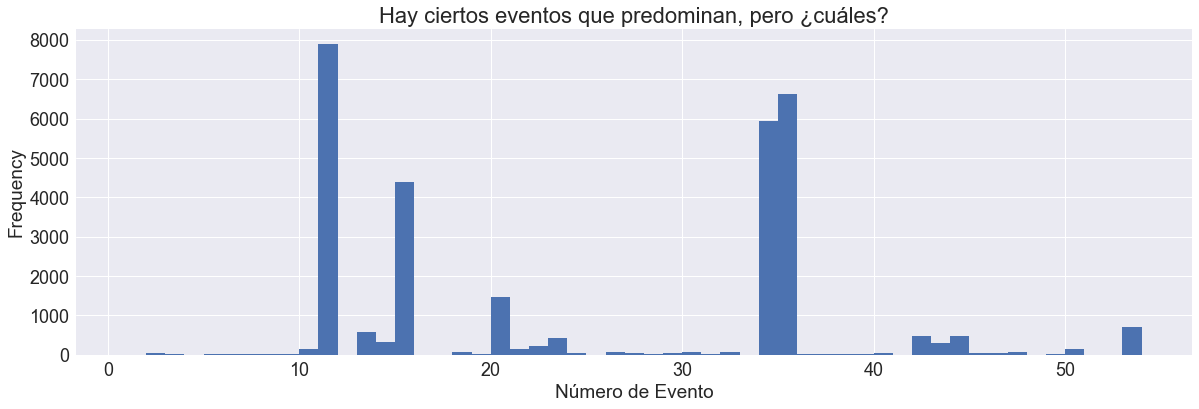

In [783]:
plt.figure(figsize=(20,6))
event.event_number.hist(bins=53)
plt.ylabel('Frequency', fontsize = 19)
plt.xlabel('Número de Evento', fontsize = 19)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.title('Hay ciertos eventos que predominan, pero ¿cuáles?', fontsize = 22);

In [784]:
h = pd.DataFrame(event.event_type.value_counts(ascending=True))
h.event_type = (h.event_type)/len(event) * 100
h.columns = ['frecuencia_porcentual']
h.tail(10)

,frecuencia_porcentual
event_type 23,1.376323
event_type 44,1.495027
event_type 42,1.533526
event_type 13,1.867180
event_type 54,2.194418
event_type 20,4.677575
event_type 15,14.100096
event_type 34,19.015079
event_type 35,21.222329
event_type 11,25.306384


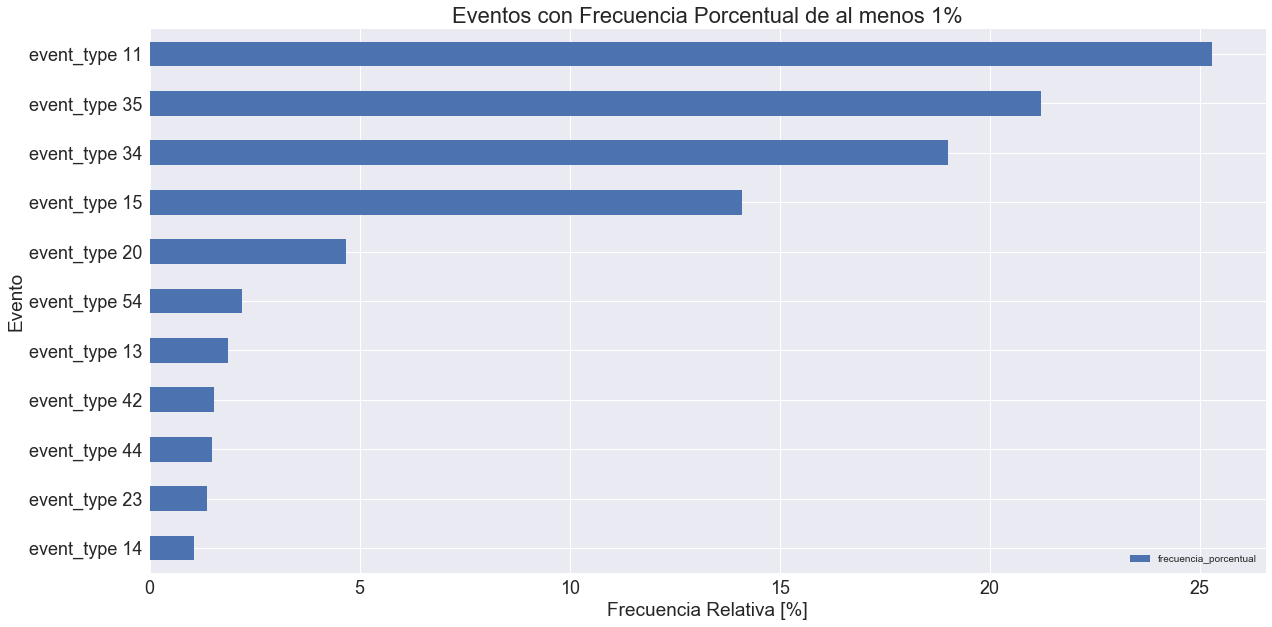

In [785]:
h[h.frecuencia_porcentual >= 1].plot.barh(figsize=(20,10))
plt.ylabel('Evento', fontsize = 19)
plt.xlabel('Frecuencia Relativa [%]', fontsize = 19)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.title('Eventos con Frecuencia Porcentual de al menos 1%', fontsize = 22);

Dado que tenemos un problema desbalanceado, es probable que los eventos más frecuentes puedan caracterizar el fault_severity = 0 dado que esta es una severidad que se presenta en el 60% de los datos. Hay que cruzar *event_type* con el *train* para tratar de probar esta conjetura.

### Log Feature

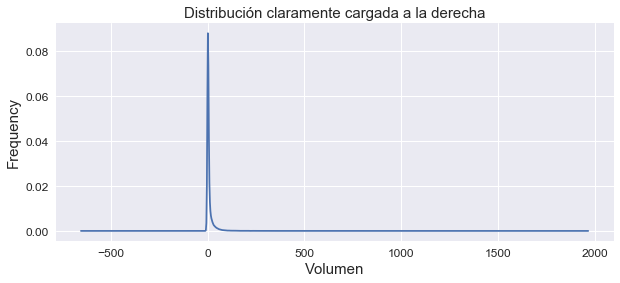

In [786]:
plt.figure(figsize=(10,4))
log_feature.volume.plot(kind = 'density')
plt.ylabel('Frequency', fontsize = 15)
plt.xlabel('Volumen', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Distribución claramente cargada a la derecha', fontsize = 15);

Dado que tenemos una distribución cargada a la derecha, probemos una transformación logarítmica para arreglarla:

In [787]:
log_feature.volume = (((np.log2(((log_feature.volume - np.mean(log_feature.volume))/np.std(log_feature.volume))**2))))

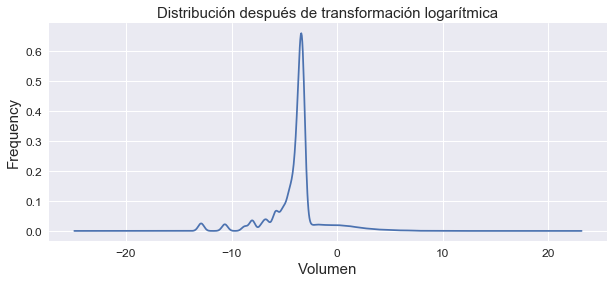

In [788]:
plt.figure(figsize=(10,4))
log_feature.volume.plot(kind = 'density')
plt.ylabel('Frequency', fontsize = 15)
plt.xlabel('Volumen', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Distribución después de transformación logarítmica', fontsize = 15);

Sigamos adelante.

In [789]:
feature = []

for i in range(len(log_feature)):
    x = int(log_feature.log_feature[i].split(" ")[1])
    feature.append(x)

log_feature['feature_number'] = feature

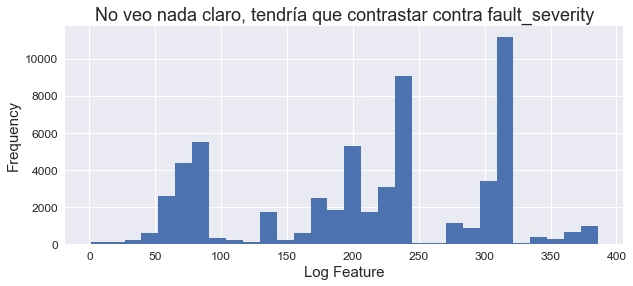

In [790]:
plt.figure(figsize=(10,4))
log_feature.feature_number.hist(bins=30)
plt.ylabel('Frequency', fontsize = 15)
plt.xlabel('Log Feature', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('No veo nada claro, tendría que contrastar contra fault_severity', fontsize = 18);


### Resource

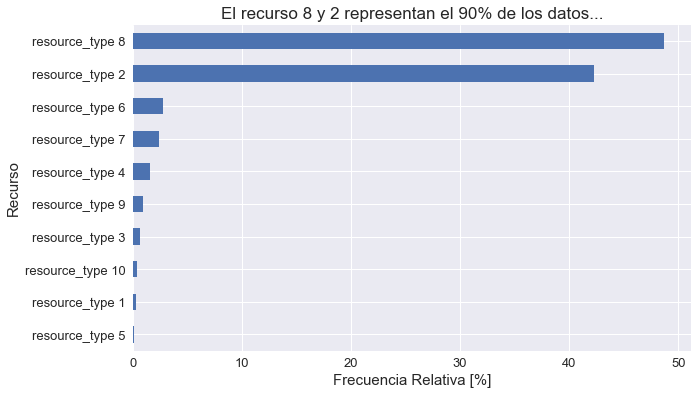

In [791]:
t = (resource.resource_type.value_counts(normalize = True,ascending = True))*100
t.plot.barh(figsize=(10,6))
plt.ylabel('Recurso', fontsize = 15)
plt.xlabel('Frecuencia Relativa [%]', fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('El recurso 8 y 2 representan el 90% de los datos...', fontsize = 17);

Dado que prácticamente todo es recurso 2 y 8 yo pensaría que está variable no va a servir de mucho como predictora.

### Severity

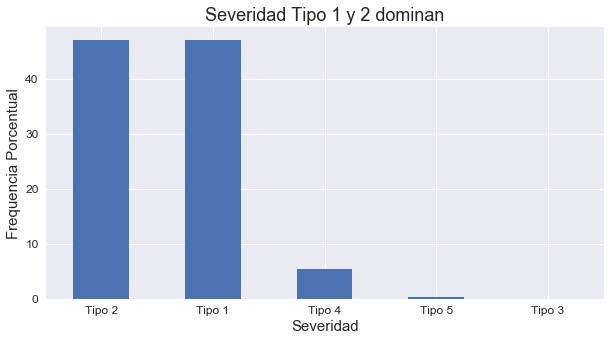

In [792]:
s = (severity.severity_type.value_counts(normalize = True)) * 100

plt.figure(figsize=(10,5))
s.plot.bar(rot = 0)
plt.ylabel('Frequencia Porcentual', fontsize = 15)
plt.xlabel('Severidad', fontsize = 15)
plt.xticks(np.arange(5), ('Tipo 2', 'Tipo 1', 'Tipo 4', 'Tipo 5', 'Tipo 3'),fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Severidad Tipo 1 y 2 dominan', fontsize = 18);

Dado que sólo representa el 5% de los casos y las fallas tipo 2 están más o menos en ese porcentaje de datos, quizás este tipo 4 esté relacionado de alguna manera.

## Preprocesamiento de Datos

In [793]:
def preconcatanation(data, col):
    # Genera columnas con todos los 
    duplicados = data[data.id.duplicated() == True]
    no_duplicados = data[data.id.duplicated() == False]

    i = duplicados.id.value_counts().index[0]
    j = duplicados.id.value_counts()[i]
    new = no_duplicados
    
    k = 2
    while j > 1:

        duplicados = duplicados[duplicados.id.duplicated() == True]
        no_duplicados = duplicados[duplicados.id.duplicated() == False]
        no_duplicados.columns = ['id', str(k)]
        new = pd.merge(new,no_duplicados, how = 'left', on = ['id'])
        k = k+1
        i = duplicados.id.value_counts().index[0]
        j = duplicados.id.value_counts()[i]

    duplicados.columns = ['id', str(k)]
    new = pd.merge(new,duplicados, how = 'left', on = ['id'])
    
    new.fillna('NoAplica', inplace = True)
    recursos = []
    for i in range(len(new)):
        x = str(new.iloc[i,1])
        n = len(new.columns)
        for j in range(2,n):
            if new.iloc[i,j] != 'NoAplica':
                y = str(new.iloc[i,j])
                x = x +','+ y
            else:
                pass
        recursos.append(x)
    
    new[str(col)] = recursos
    new = new[['id', str(col)]]
    return new

### New Resources

In [794]:
new_resource = preconcatanation(resource,'recursos')

In [795]:
resource_dummies = new_resource.recursos.str.get_dummies(sep=',')
resource_dummies['número_de_recursos'] = resource_dummies.sum(axis=1)

In [796]:
new_resource.drop('recursos', axis =1,inplace = True)
new_resource = pd.concat([new_resource,resource_dummies],axis = 1)

In [797]:
new_resource.id.nunique()

18552

### New_Log_Feature

In [798]:
data = log_feature[['id', 'log_feature']]

In [799]:
log_feature[log_feature.id == 5022]

,id,log_feature,volume,feature_number
3,5022,feature 172,-3.658957,172
4,5022,feature 56,-3.306009,56
5,5022,feature 193,-4.528688,193
6,5022,feature 71,-4.061176,71


In [800]:
new_log_feature = preconcatanation(data, 'log_features')

In [801]:
log_dummies = new_log_feature.log_features.str.get_dummies(sep=',')

In [802]:
new_log_feature.drop('log_features', axis =1,inplace = True)
new_log_feature = pd.concat([new_log_feature,log_dummies],axis = 1)

In [803]:
avg_volumen = log_feature.groupby('id').volume.mean()

In [804]:
avg_volumen.head()

id
1   -3.541307
2   -3.306009
3   -3.658957
4   -4.061176
5   -7.266640
Name: volume, dtype: float64

In [805]:
new_log_feature = pd.merge(new_log_feature,avg_volumen, how = 'left', on=['id'])

In [806]:
new_log_feature.id.nunique()

18552

## Evento

In [807]:
data = event[['id','event_type']]
new_event = preconcatanation(data, 'event')

In [808]:
event_dummies = new_event.event.str.get_dummies(sep=',')

In [809]:
new_event.drop('event', axis =1,inplace = True)
new_event = pd.concat([new_event,event_dummies],axis = 1)

In [810]:
new_event.head()

,id,event_type 1,event_type 10,event_type 11,event_type 12,event_type 13,event_type 14,event_type 15,event_type 17,event_type 18,...,event_type 49,event_type 5,event_type 50,event_type 51,event_type 53,event_type 54,event_type 6,event_type 7,event_type 8,event_type 9
0,6597,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8011,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2597,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5022,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6852,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [811]:
new_event.id.nunique()

18552

## Análisis Exploratorio Descriptivo 2

In [812]:
train_fault = train[['id', 'fault_severity']]

In [813]:
def paste_function(a,b):
    c = pd.merge(a,b,how='left',on=['id'])
    return c

In [814]:
for i in [new_event, new_log_feature, new_resource, severity]:
    train_fault = paste_function(train_fault, i)

In [815]:
fault_0 = train_fault[train_fault.fault_severity == 0]
fault_1 = train_fault[train_fault.fault_severity == 1]
fault_2 = train_fault[train_fault.fault_severity == 2]

In [816]:
def graficar_barh(cols):
    for j,i in enumerate([fault_0,fault_1,fault_2]):
        h = ((i[cols].sum())/len(i) *100).head(10)
        
        print('='*80)
        h.sort_values(ascending = True).plot.barh(figsize=(10,6))
        plt.title('fault_'+ str(j) )
        plt.show();

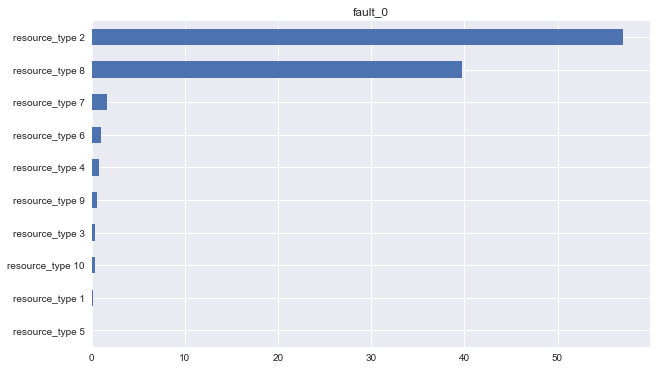

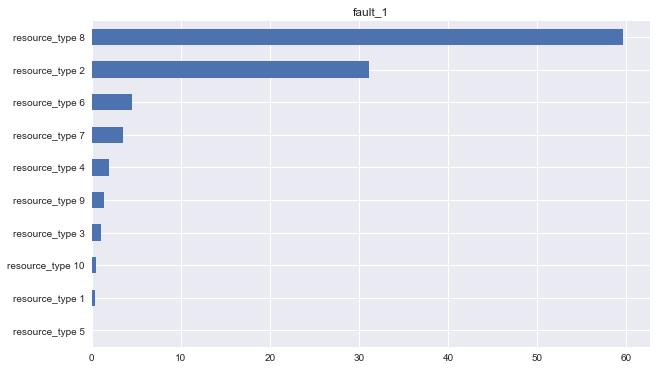

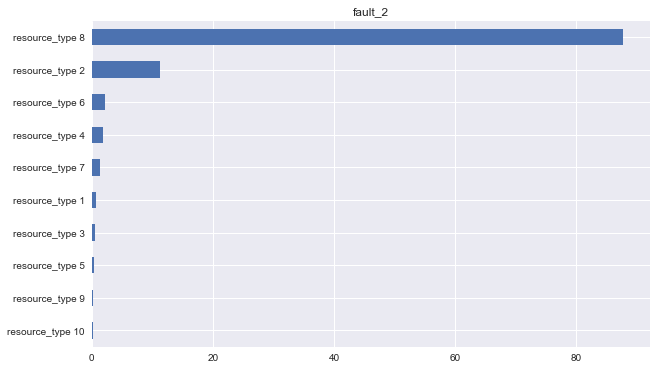

In [817]:
graficar_barh(['resource_type 1', 'resource_type 10', 'resource_type 2',
           'resource_type 3', 'resource_type 4', 'resource_type 5',
           'resource_type 6', 'resource_type 7', 'resource_type 8',
           'resource_type 9'])

El recurso 8 no parece ser relevante ya que está presente en todas los tipos de fallas, sin embargo, el recurso 2 se presenta en 40 y 30% de las veces fallas 0 y 1 y apenas un 10% en las fallas 2 por lo que esté recurso sí podría servir como predictor. En cuanto a los demás recursos son demasiado infrecuentes como para decir algo al respecto, quizás un balanceo de clases logre revelarle algo al modelo que a simple vista no es posible ver. 

No parece haber una relación numérica con las fallas por lo que dejaremos esta variable como categórica.

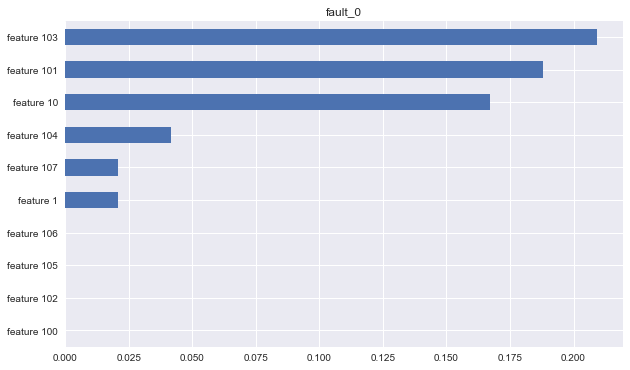

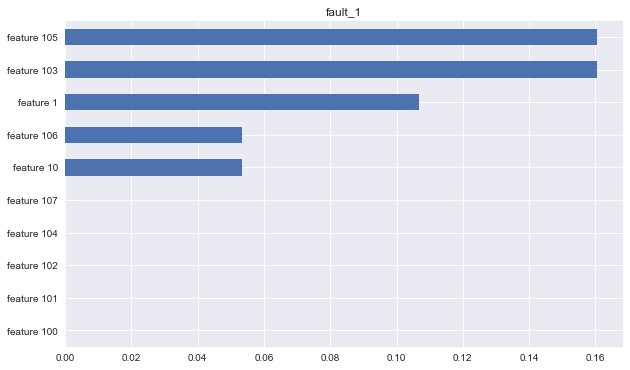

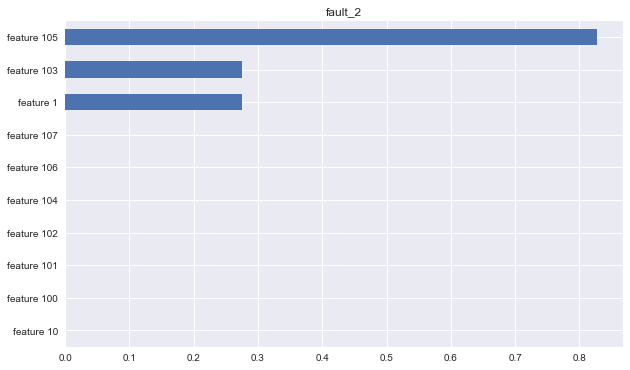

In [818]:
graficar_barh(log_dummies.columns)

Quizás el log 105 podría caracterizar fallas del tipo 1 y 2, pero no hay nada claro al respecto. Hay demasiados logs y todos se repiten el suficiente número de veces para que ninguno sea relevante. Se queda categórica.

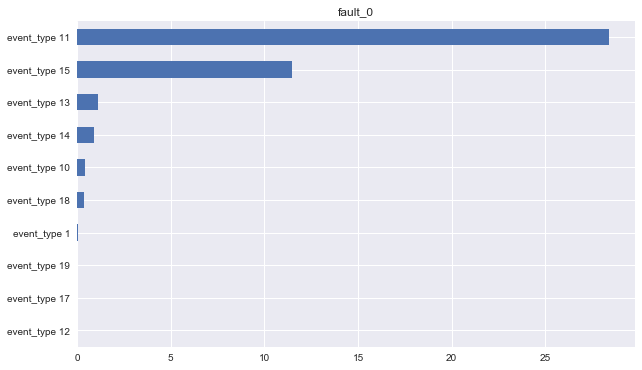

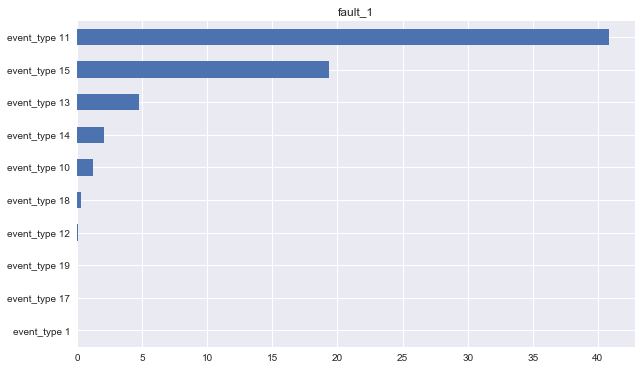

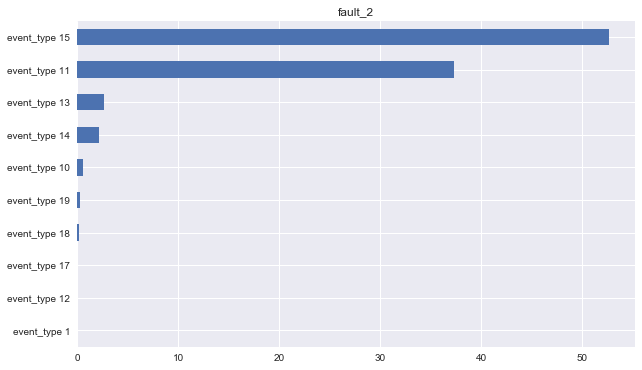

In [819]:
graficar_barh(event_dummies.columns)

Se repiten los mismos eventos y prácticamente en el mismo orden, no hay a la vista algún patrón que pueda servir.

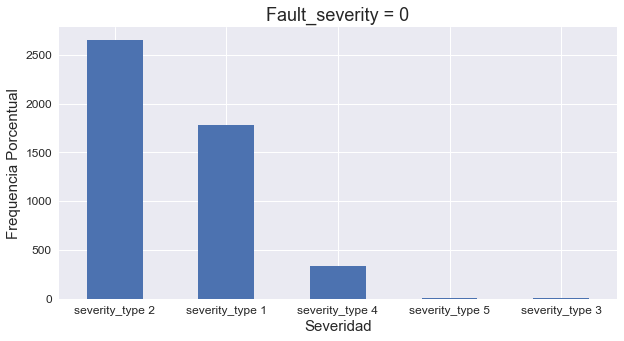

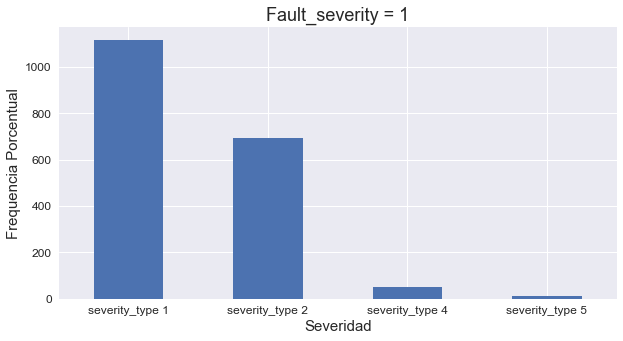

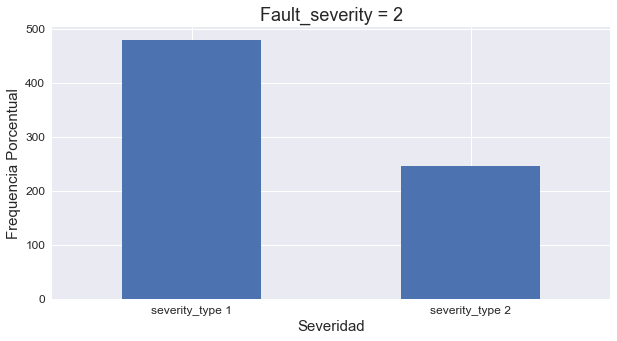

In [820]:
for i, j in enumerate([fault_0, fault_1, fault_2]):
    
    print('=='*69)
    plt.figure(figsize=(10,5))
    j.severity_type.value_counts().plot.bar(rot = 0)
    plt.ylabel('Frequencia Porcentual', fontsize = 15)
    plt.xlabel('Severidad', fontsize = 15)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title('Fault_severity = ' + str(i), fontsize = 18);
    plt.show()

Pareciera que eventos de severidad 3,4 y 5 están más asociados a fault_severity 0 y 1, están podrían ser buenas para predecir. Quizás convenga hacer numérica esta variable, pero no estoy muy seguro al respecto.

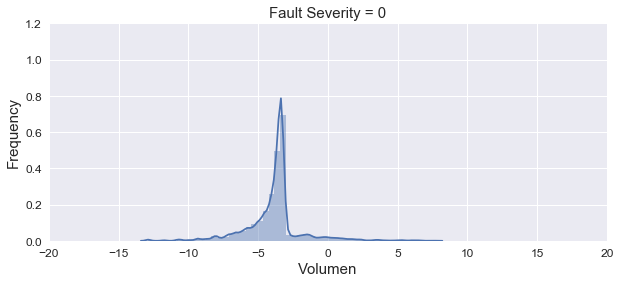

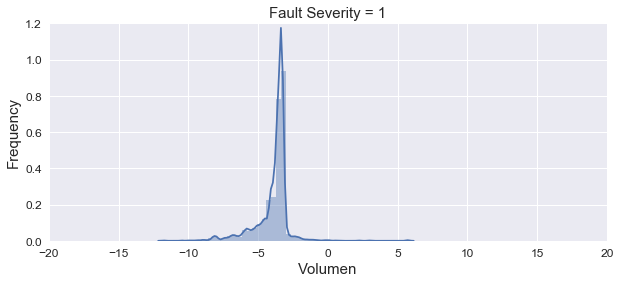

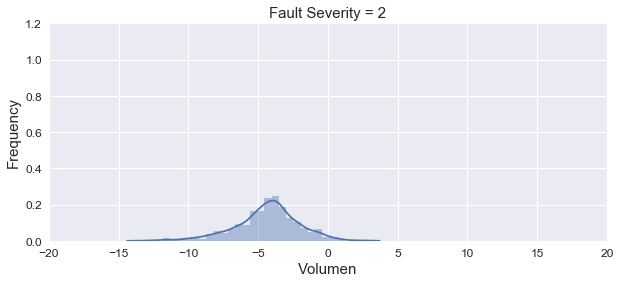

In [821]:
for i,j in enumerate([fault_0, fault_1, fault_2]):
    
    plt.figure(figsize=(10,4))
    sns.distplot(j.volume)
    plt.ylabel('Frequency', fontsize = 15)
    plt.xlabel('Volumen', fontsize = 15)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlim(-20,20)
    plt.ylim(0.0,1.2)
    plt.title('Fault Severity = ' + str(i), fontsize = 15);

Esta variable podría ser crucial para determinar fault_severity = 1 pues, como se observa en el density plot, los valores para fault_severity =  1 no pasan del -2.5, pero en el fault_severity 0 y 2 incluso pueden llegar a ser positivos. La mantenemos numérica.

In [822]:
t = train_fault[['fault_severity', 'número_de_recursos']]

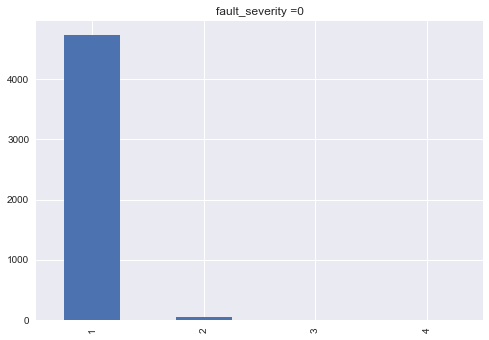

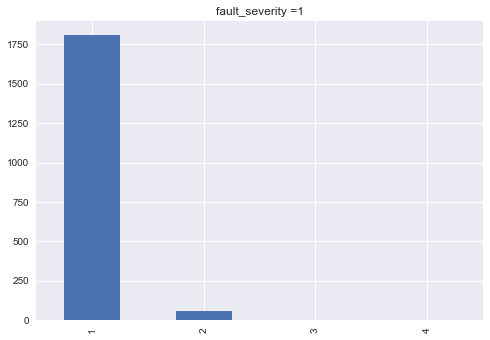

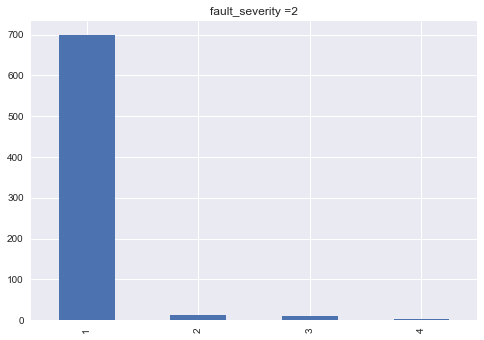

In [823]:
for i in [0,1,2]:
    
    t[t.fault_severity == i].número_de_recursos.value_counts().plot.bar()
    plt.title('fault_severity =' + str(i))
    plt.show()

Pareciera que el número de recursos sí aumenta la probabilidad de que haya fallas tipo 1 y 2, pero, dado que el problema está desbalanceado, no tenemos suficientes datos como para asegurarlo. Probablemente tengamos que generar más datos.

## Data...Assemble!

In [824]:
train.drop('location', axis = 1, inplace = True)

In [825]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 3 columns):
id                 7381 non-null int64
fault_severity     7381 non-null int64
location_number    7381 non-null int32
dtypes: int32(1), int64(2)
memory usage: 144.2 KB


In [826]:
len(train)+len(test)

18552

In [827]:
location = []
for i in range(0, len(test)):
    x = test.location[i].split(" ")[1]
    location.append(x)
    
test['location_number'] = location
test.location_number = test.location_number.astype(int)

In [828]:
test.drop('location', axis = 1, inplace = True)

In [829]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11171 entries, 0 to 11170
Data columns (total 2 columns):
id                 11171 non-null int64
location_number    11171 non-null int32
dtypes: int32(1), int64(1)
memory usage: 131.0 KB


In [830]:
new_resource.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18552 entries, 0 to 18551
Data columns (total 12 columns):
id                    18552 non-null float64
resource_type 1       18552 non-null int64
resource_type 10      18552 non-null int64
resource_type 2       18552 non-null int64
resource_type 3       18552 non-null int64
resource_type 4       18552 non-null int64
resource_type 5       18552 non-null int64
resource_type 6       18552 non-null int64
resource_type 7       18552 non-null int64
resource_type 8       18552 non-null int64
resource_type 9       18552 non-null int64
número_de_recursos    18552 non-null int64
dtypes: float64(1), int64(11)
memory usage: 2.5 MB


In [831]:
new_log_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18552 entries, 0 to 18551
Columns: 375 entries, id to volume
dtypes: float64(1), int64(374)
memory usage: 53.2 MB


In [832]:
new_event.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18552 entries, 0 to 18551
Data columns (total 52 columns):
id               18552 non-null int64
event_type 1     18552 non-null int64
event_type 10    18552 non-null int64
event_type 11    18552 non-null int64
event_type 12    18552 non-null int64
event_type 13    18552 non-null int64
event_type 14    18552 non-null int64
event_type 15    18552 non-null int64
event_type 17    18552 non-null int64
event_type 18    18552 non-null int64
event_type 19    18552 non-null int64
event_type 2     18552 non-null int64
event_type 20    18552 non-null int64
event_type 21    18552 non-null int64
event_type 22    18552 non-null int64
event_type 23    18552 non-null int64
event_type 24    18552 non-null int64
event_type 25    18552 non-null int64
event_type 26    18552 non-null int64
event_type 27    18552 non-null int64
event_type 28    18552 non-null int64
event_type 29    18552 non-null int64
event_type 3     18552 non-null int64
event_type 30    

In [833]:
severity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18552 entries, 0 to 18551
Data columns (total 2 columns):
id               18552 non-null int64
severity_type    18552 non-null object
dtypes: int64(1), object(1)
memory usage: 290.0+ KB


In [834]:
severity = pd.get_dummies(severity)

In [835]:
new_event.isnull().sum().sum()

0

In [836]:
new_log_feature.isnull().sum().sum()

0

In [837]:
new_resource.isnull().sum().sum()

0

In [838]:
severity.isnull().sum().sum()

0

In [839]:
train['source'] = 'train' 
test['source'] = 'test'

In [840]:
len(train) + len(test)

18552

In [841]:
whole_data = pd.concat([train, test], ignore_index=True, sort=False)

In [842]:
whole_data.id.nunique()

18552

In [843]:
for i in [new_event, new_log_feature, new_resource, severity]:
    whole_data = paste_function(whole_data, i)

In [844]:
whole_data.head()

,id,fault_severity,location_number,source,event_type 1,event_type 10,event_type 11,event_type 12,event_type 13,event_type 14,...,resource_type 6,resource_type 7,resource_type 8,resource_type 9,número_de_recursos,severity_type_severity_type 1,severity_type_severity_type 2,severity_type_severity_type 3,severity_type_severity_type 4,severity_type_severity_type 5
0,14121,1.0,118,train,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,9320,0.0,91,train,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,14394,1.0,152,train,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,8218,1.0,931,train,0,0,0,0,0,0,...,0,0,1,0,1,1,0,0,0,0
4,14804,0.0,120,train,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [845]:
whole_data.id.nunique()

18552

Revisando que no hayan pasado cosas raras:

In [846]:
train_2 = whole_data[whole_data.source == 'train']

In [847]:
train_2.isnull().sum().sum()

0

In [848]:
test_2 = whole_data[whole_data.source == 'test']

In [849]:
test_2.drop('fault_severity', axis = 1, inplace = True)

C:\Users\Tycho Brahe\INSTALCONDA\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [850]:
test_2.isnull().sum().sum()

0

# Outliers

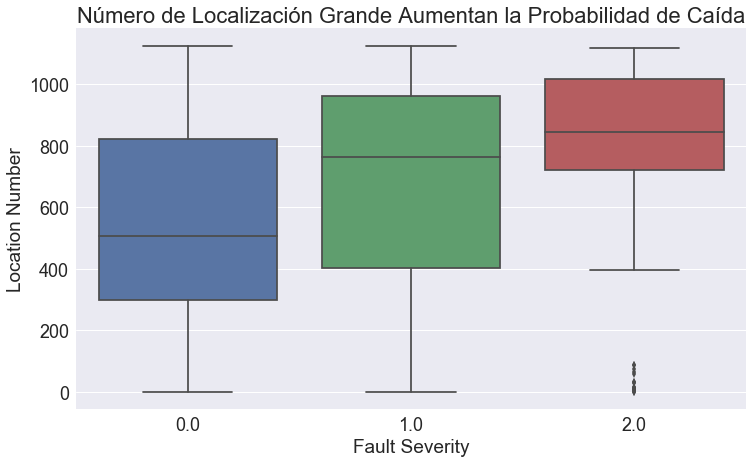

In [851]:
sns.catplot(x="fault_severity", y="location_number", kind="box", data=train_2[['fault_severity','location_number']], height=6, aspect =1.7)
plt.xlabel('Fault Severity', fontsize = 19)
plt.ylabel('Location Number', fontsize = 19)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.title('Número de Localización Grande Aumentan la Probabilidad de Caída', fontsize = 22);

In [852]:
i = train_2[(train_2.location_number < 500) & (train_2.fault_severity == 2)].index

In [853]:
train_2 = train_2.drop(i).reset_index(drop=True)

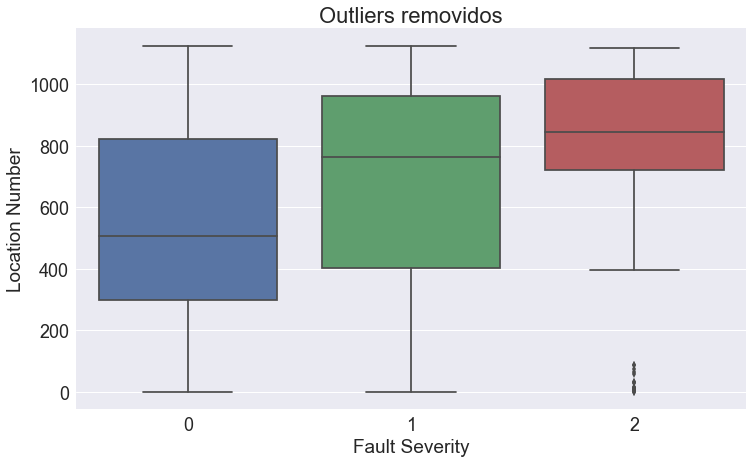

In [854]:
sns.catplot(x="fault_severity", y="location_number", kind="box", data=train[['fault_severity','location_number']], height=6, aspect =1.7)
plt.xlabel('Fault Severity', fontsize = 19)
plt.ylabel('Location Number', fontsize = 19)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.title('Outliers removidos', fontsize = 22);

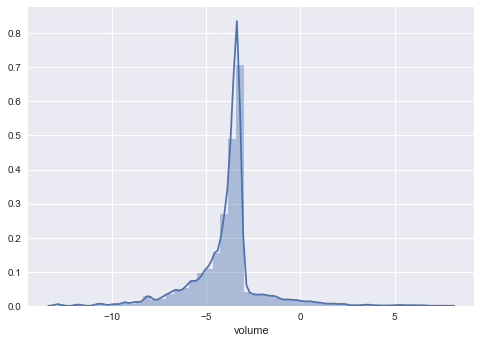

In [855]:
sns.distplot(train_2.volume)

Quedémonos sólo con la data entre -10 y 5 pues esos son los intervalos relevantes para la predicción que buscamos.

In [856]:
i = train_2[(train_2.volume > 5) | (train_2.volume < -10)].index

In [857]:
train_2 = train_2.drop(i).reset_index(drop=True)

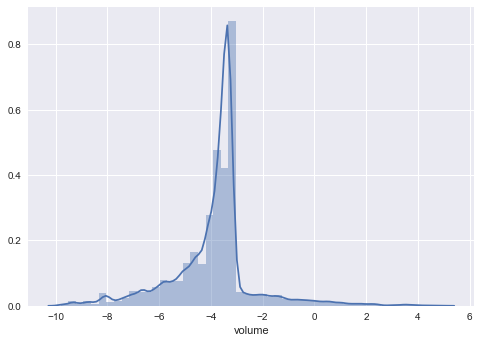

In [858]:
sns.distplot(train_2.volume)

In [859]:
train_2.volume.describe()

count    7275.000000
mean       -3.875286
std         1.664926
min        -9.805668
25%        -4.491796
50%        -3.658957
75%        -3.306009
max         4.935339
Name: volume, dtype: float64

No estoy muy seguro de querer tirar outliers en las demás variables...

# Machine Learning

In [865]:
pd.read_csv("sample_submission.csv")['id'].head()

0    11066
1    18000
2    16964
3     4795
4     3392
Name: id, dtype: int64

In [864]:
test_2['id'].head()

7381    11066
7382    18000
7383    16964
7384     4795
7385     3392
Name: id, dtype: int64

In [866]:
train_ = train_2
test_ = test_2

In [867]:
train.drop(['id','source'], axis = 1, inplace = True)
test.drop(['id','source'], axis = 1, inplace = True)

In [868]:
y_train = train.fault_severity
X_train = train.iloc[:,1:]
X_test = test